In [1]:
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer import Layer
from math import sqrt
import math
import numpy as np
from tensorflow.keras.layers import LeakyReLU
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from Energy_Models import Models as mo
from Data import preprocess_data as pr

In [2]:
df = pd.read_csv('D:\College\Final\Gpr\Datasets\household_power_consumption.txt',sep=';', 
                 parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.shape

(2075259, 7)

In [6]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
# filling missing values by the value of one day before 
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row,col]):
                data[row,col] = data[row-one_day,col]

In [8]:
fill_missing(df.values)

In [9]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [10]:
# Compute remaining active power
df['sub_metering_remaining'] = (df.Global_active_power * 1000  / 60 ) - (df.Sub_metering_1 + df.Sub_metering_2 + df.Sub_metering_3)

In [11]:
# descriptive statistics
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00,9.298722e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00,9.561278e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


In [12]:
# resample the data on daily basis
df = df.resample('D').mean()
df.shape

(1442, 8)

In [13]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [52]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [53]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [54]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [55]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_UNI_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (1008, 1, 7) and ouput feature (1008,)


In [56]:
# Split the testing data into input features and out feature
X_test, Y_test = pr.convert_UNI_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (432, 1, 7) and ouput feature (432,)


In [57]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [58]:
n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
model=mo.BiLSTM(n_steps,n_features,n_outputs).getModel()
model.compile(optimizer='adam', loss ='mae')
history = model.fit(X_train , Y_train, epochs=100, batch_size=128, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/100
7/7 [==============================] - 4s 83ms/step - loss: 0.2863 - val_loss: 0.1872
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.2345 - val_loss: 0.1250
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1654 - val_loss: 0.0720
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1178 - val_loss: 0.1321
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 0.1200 - val_loss: 0.0913
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1093 - val_loss: 0.0722
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1104 - val_loss: 0.0744
Epoch 8/100
7/7 [==============================] - 0s 10ms/step - loss: 0.1067 - val_loss: 0.0842
Epoch 9/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1086 - val_loss: 0.0789
Epoch 10/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1020 - val_loss: 0.0696
Epoch 11/100
7/7 [=

In [59]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0760
evaluation : 0.076 
14/14 [==============================] - 0s 2ms/step - loss: 0.0587
evaluation : 0.059 


In [60]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

14/14 [==============================] - 0s 2ms/step


In [61]:
mo.print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train RMSE value   : 0.105 
Train MSE value    : 0.011 
Train R2 value     : 0.458 
Train MAPE value   : 308639590823.361 
Train RMLSE value  : 0.006 
Train MAE value    : 0.076 
---------------------------------------------
Test RMSE value   : 0.078 
Test MSE value   : 0.006 
Test R2 value   : 0.447 
Test MAPE value  : 0.243 
Test RMLSE value  : 0.004 
Test MAE value : 0.059 


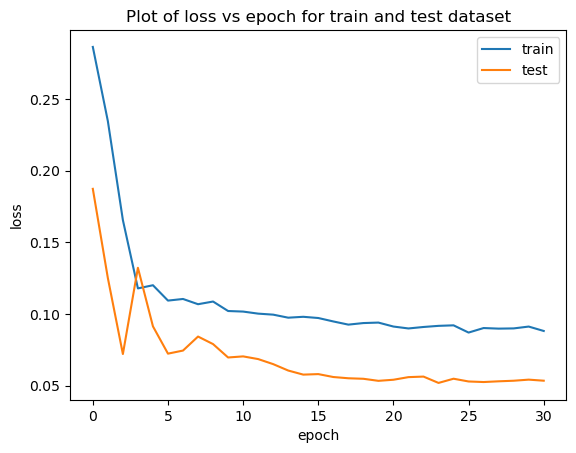

In [62]:
import matplotlib.pyplot as plt 
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [63]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [64]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [65]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_Multi_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (982, 21, 7) and ouput feature (982, 7)


In [66]:
X_test, Y_test = pr.convert_Multi_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (406, 21, 7) and ouput feature (406, 7)


In [74]:
n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
model = mo.BiLSTM(n_steps,n_features,n_outputs).getModel()
model.compile(optimizer='adam', loss ='mse')
history = model.fit(X_train , Y_train, epochs=200, batch_size=256, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/200
4/4 [==============================] - 4s 311ms/step - loss: 0.0969 - val_loss: 0.0323
Epoch 2/200
4/4 [==============================] - 1s 145ms/step - loss: 0.0596 - val_loss: 0.0203
Epoch 3/200
4/4 [==============================] - 1s 184ms/step - loss: 0.0442 - val_loss: 0.0111
Epoch 4/200
4/4 [==============================] - 1s 182ms/step - loss: 0.0360 - val_loss: 0.0073
Epoch 5/200
4/4 [==============================] - 1s 147ms/step - loss: 0.0320 - val_loss: 0.0077
Epoch 6/200
4/4 [==============================] - 1s 159ms/step - loss: 0.0309 - val_loss: 0.0077
Epoch 7/200
4/4 [==============================] - 1s 149ms/step - loss: 0.0296 - val_loss: 0.0066
Epoch 8/200
4/4 [==============================] - 1s 155ms/step - loss: 0.0288 - val_loss: 0.0061
Epoch 9/200
4/4 [==============================] - 1s 150ms/step - loss: 0.0272 - val_loss: 0.0059
Epoch 10/200
4/4 [==============================] - 1s 147ms/step - loss: 0.0264 - val_loss: 0.0059
Epoch 11/

In [75]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

31/31 [==============================] - 0s 13ms/step - loss: 0.0113
evaluation : 0.011 
13/13 [==============================] - 0s 14ms/step - loss: 0.0076
evaluation : 0.008 


In [76]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

13/13 [==============================] - 0s 17ms/step


In [77]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [78]:
def print_metrics(model,Y_train,Y_pred_train,Y_test,Y_pred_test):
    print('Train MAE  value   : %.3f ' % mean_absolute_error(Y_train, Y_pred_train))
    print('Train MSE  value   : %.3f ' % mean_squared_error(Y_train, Y_pred_train))
    print('Train RMSE value   : %.3f ' % root_mean_squared_error(Y_train, Y_pred_train))
    print('Train R2   value   : %.3f ' % r2_score(Y_train, Y_pred_train))
    print('---------------------------------------------')
    print('Test  MAE  value   : %.3f ' % mean_absolute_error(Y_test, Y_pred_test))
    print('Test  MSE  value   : %.3f ' % mean_squared_error(Y_test, Y_pred_test))
    print('Test  RMSE value   : %.3f ' % root_mean_squared_error(Y_test, Y_pred_test))
    print('Test  R2   value   : %.3f ' % r2_score(Y_test, Y_pred_test))
print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train MAE  value   : 0.080 
Train MSE  value   : 0.011 
Train RMSE value   : 0.107 
Train R2   value   : 0.396 
---------------------------------------------
Test  MAE  value   : 0.066 
Test  MSE  value   : 0.008 
Test  RMSE value   : 0.087 
Test  R2   value   : 0.343 


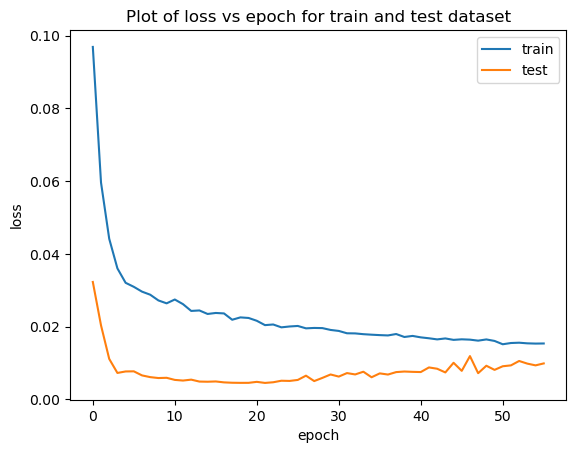

In [79]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()